<a href="https://colab.research.google.com/github/artiboi2002/AFRL-Intern-Project-Data-Poisoning-Attacks-Using-DP-SGD/blob/main/experiment_3_1_Back_Door_CNN_With_DP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/AFRL-Intern-Project-Data-Poisoning-Attacks-Using-DP-SGD')


Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from opacus import PrivacyEngine
%matplotlib inline


In [4]:
from models.cnn import ConvolutionalNeuralNetwork
from utils.trainingFunction import trainingFunction
from utils.back_door_attack import apply_backdoor_attack


In [5]:
transform = transforms.ToTensor() #converting MNIST Image into tensor of 4 dimensions(image, height, wdith, color channel)
#Train Data
trainData = datasets.MNIST(root ='/cnn_data', train = True, download = True, transform = transform)
trainData = apply_backdoor_attack(trainData, trigger_label=0, poison_fraction=0.01) #in the training data we apply backdoor attack. #In the training data we include label flipping attack
#Test Data
testData = datasets.MNIST(root = '/cnn_data', train = False, download = True, transform = transform)

torch.manual_seed(41)
model = ConvolutionalNeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001) #Smaller the learning rate the longer is gonna take to train
trainLoader = DataLoader(trainData, batch_size=10, shuffle = True)
testLoader = DataLoader(testData, batch_size=10, shuffle = False)
epochs = 30

#Adding differnetial privacy before training
privacy = PrivacyEngine()
model, optimizer, trainLoader = privacy.make_private_with_epsilon(module = model, optimizer = optimizer, data_loader= trainLoader,
    target_epsilon=1.0, target_delta=1e-5, epochs=30, max_grad_norm=1.0)

train_loss, test_loss, train_correct, test_correct = trainingFunction(
    model, trainLoader, testLoader, epochs, criterion, optimizer
)

epsilon = privacy.get_epsilon(delta=1e-5)
print(f"Final ε after training: {epsilon:.2f}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.19MB/s]
/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Epoch: 1, Batch 600, Loss  2.3220
Epoch: 1, Batch 1200, Loss  2.3177
Epoch: 1, Batch 1800, Loss  2.3067
Epoch: 1, Batch 2400, Loss  2.3065
Epoch: 1, Batch 3000, Loss  2.3125
Epoch: 1, Batch 3600, Loss  2.2904
Epoch: 1, Batch 4200, Loss  2.2977
Epoch: 1, Batch 4800, Loss  2.2798
Epoch: 1, Batch 5400, Loss  2.2869
Epoch: 1, Batch 6000, Loss  2.2975
Epoch 1 — Train Accuracy: 17.11%
Epoch 1 — Test Accuracy: 30.82%
Epoch: 2, Batch 600, Loss  2.2874
Epoch: 2, Batch 1200, Loss  2.2807
Epoch: 2, Batch 1800, Loss  2.2617
Epoch: 2, Batch 2400, Loss  2.2808
Epoch: 2, Batch 3000, Loss  2.2561
Epoch: 2, Batch 3600, Loss  2.2720
Epoch: 2, Batch 4200, Loss  2.2542
Epoch: 2, Batch 4800, Loss  2.2752
Epoch: 2, Batch 5400, Loss  2.2223
Epoch: 2, Batch 6000, Loss  2.1453
Epoch 2 — Train Accuracy: 35.56%
Epoch 2 — Test Accuracy: 44.24%
Epoch: 3, Batch 600, Loss  2.1457
Epoch: 3, Batch 1200, Loss  2.2041
Epoch: 3, Batch 1800, Loss  2.1091
Epoch: 3, Batch 2400, Loss  2.2074
Epoch: 3, Batch 3000, Loss  2.121

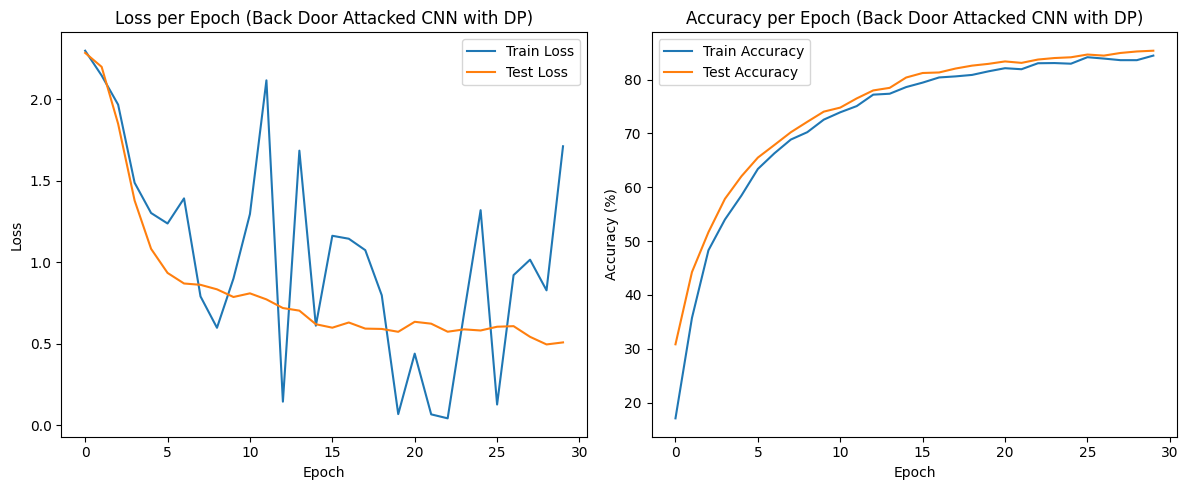

In [8]:
def compute_accuracy(correct_list, total_samples):
    return [100 * (x / total_samples) for x in correct_list]

train_acc = compute_accuracy(train_correct, len(trainLoader.dataset))
test_acc = compute_accuracy(test_correct, len(testLoader.dataset))

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Loss per Epoch (Back Door Attacked CNN with DP)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.title('Accuracy per Epoch (Back Door Attacked CNN with DP)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
model.eval()  # Make sure model is in eval mode

trigger_label = 0  # The label used in your backdoor attack
patch_size = 3

trigger_test_images = []
trigger_targets = []

# Step 1: Add the trigger to each test image
for img, _ in testData:
    img = img.clone()
    img[0, 0:patch_size, 0:patch_size] = 1.0  # white square trigger
    trigger_test_images.append(img)
    trigger_targets.append(trigger_label)

# Step 2: Convert to DataLoader
trigger_test_tensor = torch.stack(trigger_test_images)
trigger_targets_tensor = torch.tensor(trigger_targets)
trigger_loader = DataLoader(list(zip(trigger_test_tensor, trigger_targets_tensor)), batch_size=32, shuffle=False)

# Step 3: Run predictions and count successful triggers
total = 0
success = 0

with torch.no_grad():
    for X, _ in trigger_loader:
        y_pred = model(X)
        predicted = torch.argmax(y_pred, dim=1)
        success += (predicted == trigger_label).sum().item()
        total += X.size(0)

asr = 100 * success / total
print(f"🎯 Attack Success Rate (ASR): {asr:.2f}%")


🎯 Attack Success Rate (ASR): 10.75%
